<a href="https://colab.research.google.com/github/FrancescaTorazzi/jellyfish_classification-/blob/main/individui_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 960.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfu

This line imports the d2l module from the Dive into Deep Learning (D2L) library, specifically for PyTorch.

In [ ]:
from d2l import torch as d2l

Accessing the files sored in Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = "/content/drive/MyDrive/Colab Notebooks/Natural_images.zip"

In [ ]:
import os, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random

import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from torch.nn import functional as F
from tqdm import tqdm
import torch.optim as optim

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

This code imports a ZIP file from Google Drive and extracts its contents into the `/content/dataset` directory in the Google Colab environment.

In [ ]:
import zipfile  # Module to work with ZIP archives
import os       # Module to interact with the operating system

# Define the path to the ZIP file located in Google Drive
zip_path = "/content/drive/MyDrive/Colab Notebooks/Natural_images.zip"

# Define the path where the ZIP file will be extracted
extract_path = "/content/dataset"

# Extracting the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)  # Extract all contents to the specified directory

print("File extracted in:", extract_path)  # Confirm successful extraction


File extracted in: /content/dataset


In order to verify that the ZIP file was extracted correctly and to see the structure of the extracted data we printed all the files present in the extraction path.

In [ ]:
print(os.listdir(extract_path))

['natural_images', 'data']


In [ ]:
#from collections import Counter

#Count of how many files are in each folder
#data_dirs = [d for d in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, d))]
#file_counts = {d: len(os.listdir(os.path.join(extract_path, d))) for d in data_dirs}

#print(file_counts)

{'natural_images': 8, 'data': 1}


In [ ]:
import os
dataset_path = "/content/dataset/natural_images"  # Aggiorna con il percorso corretto

num_images = 0
for root, _, files in os.walk(dataset_path):
    for image_name in files:
        if image_name.endswith(('.jpg', '.png', '.jpeg')):
            num_images += 1

print(f" Total images: {num_images}")


 Total images: 6899


I want to check now how many images I have in each category

In [ ]:
# Dictionary to store the number of images per category
image_counts = {}

# Scan through the folders in the dataset
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path):  # Check if it's a directory
        # Count only files with image extensions
        num_images = sum(1 for file in os.listdir(category_path) if file.endswith(('.jpg', '.png', '.jpeg')))
        image_counts[category] = num_images

# Print the results
print("Number of images per category:")
for category, count in image_counts.items():
    print(f"  {category}: {count} images")

Number of images per category:
  motorbike: 788 images
  person: 986 images
  airplane: 727 images
  flower: 843 images
  fruit: 1000 images
  car: 968 images
  dog: 702 images
  cat: 885 images


A bar chart is created to visualize the distribution of images across different categories in the dataset.

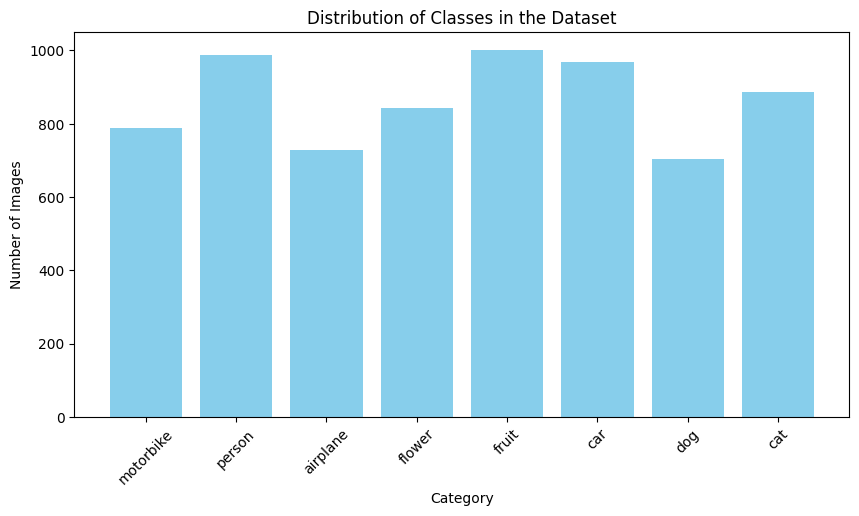

In [ ]:
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization

# Function to plot the distribution of images across categories
def plot_image_distribution(image_counts):
    plt.figure(figsize=(10, 5))  # Set the figure size for better readability

    # Create a bar chart with categories on the x-axis and image counts on the y-axis
    plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')

    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.title("Distribution of Classes in the Dataset")  # Set the title of the plot
    plt.xlabel("Category")  # Label for the x-axis
    plt.ylabel("Number of Images")  # Label for the y-axis
    plt.show()  # Display the plot

# Generate the bar chart using the image count data
plot_image_distribution(image_counts)



This code generates a pie chart to visualize the distribution of images across different categories in a dataset.

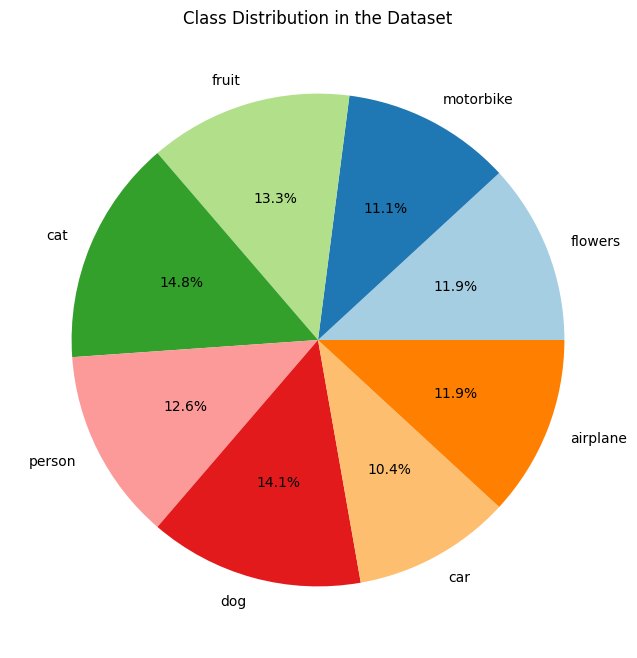

In [ ]:
import matplotlib.pyplot as plt

# Dictionary with the number of images per class (replace with your actual data)
image_counts = {
    'flowers': 800,
    'motorbike': 750,
    'fruit': 900,
    'cat': 1000,
    'person': 850,
    'dog': 950,
    'car': 700,
    'airplane': 800
}

def plot_image_distribution_pie(image_counts):
    """
    Function to generate a pie chart showing the distribution of images per class.
    """
    plt.figure(figsize=(8, 8))  # Set the figure size
    plt.pie(
        image_counts.values(),  # Image counts
        labels=image_counts.keys(),  # Class labels
        autopct='%1.1f%%',  # Display percentage with one decimal
        colors=plt.cm.Paired.colors  # Use a predefined color palette
    )
    plt.title("Class Distribution in the Dataset")  # Set the title
    plt.show()  # Display the chart

# Generate the pie chart
plot_image_distribution_pie(image_counts)


From the pie chart, it is evident that the dataset is **generally balanced**, with a relatively even distribution of images across the different categories. Although there are slight variations in the percentage of images per category, no single class significantly dominates the dataset. This balanced distribution is important for ensuring fair and unbiased model training.

### Two sample images from each category
This code generates a visual overview of the dataset by displaying two sample images from each category. It helps to quickly understand the types of images present and the overall structure of the dataset.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_sample_images(dataset_path):
    sample_images = {}  # Dictionary to store two sample images per class

    for class_name in os.scandir(dataset_path):
        if class_name.is_dir():  # Check if it's a directory (class folder)
            images = list(os.scandir(class_name.path))  # Get all images in the folder
            if len(images) >= 2:  # Ensure there are at least two images
                sample_images[class_name.name] = [images[0].path, images[1].path]

    num_classes = len(sample_images)
    fig, axes = plt.subplots(num_classes, 2, figsize=(10, 5 * num_classes))  # Create subplots for each class

    for (class_name, img_paths), ax_row in zip(sample_images.items(), axes):
        for img_path, ax in zip(img_paths, ax_row):
            with Image.open(img_path) as img:
                ax.imshow(img)  # Display the image
                ax.set_title(class_name)  # Set the title as the class name
                ax.axis("off")  # Remove axis labels

    plt.tight_layout()
    plt.show()

# Display sample images
show_sample_images(dataset_path)

### Dimensions and aspect ratios of images

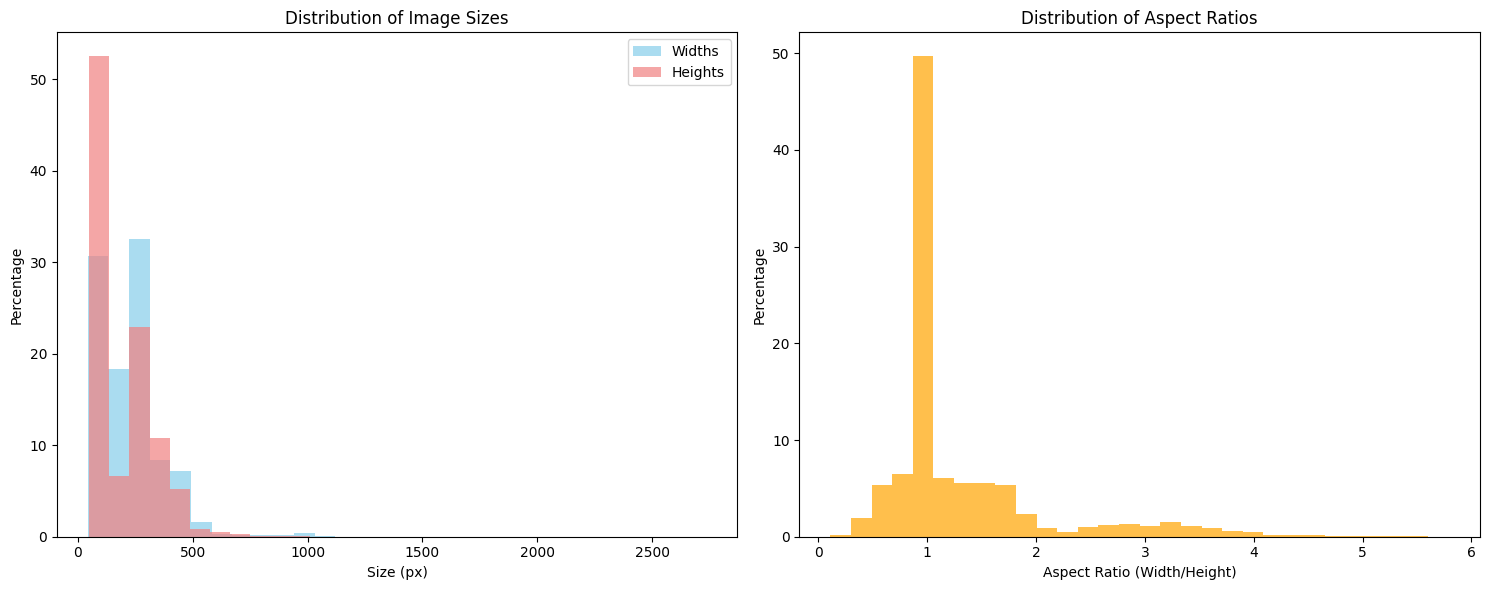

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define dataset path
dataset_path = "/content/dataset/natural_images"

# Extract image dimensions
image_sizes = []

for root, _, files in os.walk(dataset_path):  # Traverse folders and subfolders of dataset_path
    for image_name in files:
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Consider multiple image formats
            image_path = os.path.join(root, image_name)  # Full path to the image
            try:
                with Image.open(image_path) as img:
                    image_sizes.append(img.size)  # (width, height)
            except:
                continue  # Skip unreadable images

# Ensure there are images before proceeding
if len(image_sizes) > 0:
    # Analyze widths, heights, and aspect ratios
    widths = [size[0] for size in image_sizes]
    heights = [size[1] for size in image_sizes]
    aspect_ratios = [w / h for w, h in zip(widths, heights)]

    # Distribution of dimensions (width, height)
    width_counts, width_bins = np.histogram(widths, bins=30)
    height_counts, height_bins = np.histogram(heights, bins=30)
    width_percent = (width_counts / len(widths)) * 100
    height_percent = (height_counts / len(heights)) * 100

    # Distribution of aspect ratios
    aspect_counts, aspect_bins = np.histogram(aspect_ratios, bins=30)
    aspect_percent = (aspect_counts / len(aspect_ratios)) * 100

    # Plot distributions
    plt.figure(figsize=(15, 6))

    # Plot 1: Distribution of dimensions
    plt.subplot(1, 2, 1)
    plt.bar(width_bins[:-1], width_percent, width=np.diff(width_bins)[0], alpha=0.7, label='Widths', align='edge', color='skyblue')
    plt.bar(height_bins[:-1], height_percent, width=np.diff(height_bins)[0], alpha=0.7, label='Heights', align='edge', color='lightcoral')
    plt.title('Distribution of Image Sizes')
    plt.xlabel('Size (px)')
    plt.ylabel('Percentage')
    plt.legend()

    # Plot 2: Distribution of aspect ratios
    plt.subplot(1, 2, 2)
    plt.bar(aspect_bins[:-1], aspect_percent, width=np.diff(aspect_bins)[0], alpha=0.7, color='orange')
    plt.title('Distribution of Aspect Ratios')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Percentage')

    plt.tight_layout()
    plt.show()
else:
    print("No images found in the dataset. Please check the dataset path and file formats.")


1.   **Left Chart**

It represents the distribution of image widths (Widths, in blue) and heights (Heights, in red) within the dataset.
The x-axis indicates image dimensions in pixels (either width or height), while the y-axis shows the percentage of images with those dimensions.

Observations:


*  Most images have a width and height
between 0 and 500 px, suggesting that the dataset mainly contains small-sized images.


*   There is a sharp decline beyond 500 px, meaning very few images exceed this size.


*   The distributions of widths and heights appear similar, which could indicate that many images are either square or follow a common aspect ratio.


2.   **Right Chart**

The x-axis represents the width/height ratio of each image.
The y-axis shows the percentage of images with that specific aspect ratio.

Observations:

*   Most images have an aspect ratio close to 1, meaning they are almost square (width ≈ height).

*   Some images have an aspect ratio greater than 1, indicating they are wider than they are tall (landscape orientation).
*   Very few images have aspect ratios above 3 or 4, suggesting that the dataset does not contain many stretched images.


Check for corrupted images (damaged,incolpete,unreadable).


In [ ]:
from PIL import Image
import os

original_dataset_path = "/content/dataset/natural_images"

corrupted_files = []
for class_name in os.listdir(original_dataset_path):
    class_folder = os.path.join(original_dataset_path, class_name)
    if os.path.isdir(class_folder):
        print(f"Checking class '{class_name}'")
        for file in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Check if the image is valid
            except Exception as e:
                print(f"❌ Corrupted: {file_path} | Error: {e}")
                corrupted_files.append(file_path)

print(f"\nTotal corrupted files: {len(corrupted_files)}")


Checking class 'motorbike'
Checking class 'person'
Checking class 'airplane'
Checking class 'flower'
Checking class 'fruit'
Checking class 'car'
Checking class 'dog'
Checking class 'cat'

Total corrupted files: 0


In [ ]:
for file_path in corrupted_files:
    os.remove(file_path)
    print(f"Removed corrupted file: {file_path}")

To ensure consistency in the dataset and prepare the images for machine learning tasks, this process involves resizing all images to 224x224 pixels

In [ ]:
from PIL import Image
import os
from tqdm import tqdm

original_dataset_path = "/content/dataset/natural_images"
output_dataset_path = "/content/dataset/resized_images"
target_size = (224, 224)

def resize_images(original_dataset_path, output_dataset_path, target_size):
    """Resize images from original_dataset_path and save them to output_dataset_path."""
    if not os.path.exists(output_dataset_path):
        os.makedirs(output_dataset_path)

    for class_name in os.listdir(original_dataset_path):
        class_folder = os.path.join(original_dataset_path, class_name)
        output_class_folder = os.path.join(output_dataset_path, class_name)

        if os.path.isdir(class_folder):
            if not os.path.exists(output_class_folder):
                os.makedirs(output_class_folder)

            images = os.listdir(class_folder)

            for img_name in tqdm(images, desc=f"Resizing {class_name}", leave=False):
                img_path = os.path.join(class_folder, img_name)
                output_img_path = os.path.join(output_class_folder, os.path.splitext(img_name)[0] + ".jpg")

                try:
                    with Image.open(img_path) as img:
                        img = img.convert("RGB")  # Ensure RGB mode
                        img_resized = img.resize(target_size)  # Remove ANTIALIAS
                        img_resized.save(output_img_path, "JPEG")
                except Exception as e:
                    print(f"❌ Skipping corrupted image: {img_path} | Error: {e}")

# Run resizing
resize_images(original_dataset_path, output_dataset_path, target_size)


###Verification of the Resized Dataset to Ensure:
1. The correct number of images is present in each class.
2. All images are readable and can be successfully opened.
3. Every image has the correct dimensions of 224x224 pixels.



In [ ]:
import os
from PIL import Image

output_dataset_path = "/content/dataset/resized_images"

def check_resized_images(output_path, sample_check=5):
    if not os.path.exists(output_path):
        print(f"The folder '{output_path}' does not exist!")
        return

    total_images = 0
    incorrect_size = 0
    corrupted_images = 0

    print("\n Checking resized dataset...\n")

    for class_name in os.listdir(output_path):
        class_folder = os.path.join(output_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        images = os.listdir(class_folder)
        num_images = len(images)
        total_images += num_images

        print(f" Class '{class_name}': {num_images} images")

        # Sample check: Try to open some images
        for img_name in images[:sample_check]:
            img_path = os.path.join(class_folder, img_name)
            try:
                with Image.open(img_path) as img:
                    # Check if image size is correct
                    if img.size != (224, 224):
                        incorrect_size += 1
                        print(f" Incorrect size: {img_name} ({img.size}), expected (224, 224)")
            except Exception as e:
                corrupted_images += 1
                print(f" Corrupted image: {img_name} | Error: {e}")

    print("\nDataset check completed.")
    print(f"Total images: {total_images}")
    print(f"Incorrect size images: {incorrect_size}")
    print(f"Corrupted images: {corrupted_images}")

# Run the check
check_resized_images(output_dataset_path)



 Checking resized dataset...

 Class 'motorbike': 788 images
 Class 'person': 986 images
 Class 'airplane': 727 images
 Class 'flower': 843 images
 Class 'fruit': 1000 images
 Class 'car': 968 images
 Class 'dog': 702 images
 Class 'cat': 885 images

Dataset check completed.
Total images: 6899
Incorrect size images: 0
Corrupted images: 0


## Random Resampling of the Dataset
This code performs random resampling to reduce the number of images in each class to a fixed size (e.g., 300 images per class). This helps in balancing the dataset and ensuring consistency across classes for model training.



In [ ]:
import os
import shutil
import random

def resample_dataset(input_path, output_path, samples_per_class=300):
    """
    Perform random resampling to reduce the number of images per class.
    Copies a fixed number of randomly chosen images from each class.
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path, exist_ok=True)

    for class_name in os.listdir(input_path):
        class_folder = os.path.join(input_path, class_name)
        output_class_folder = os.path.join(output_path, class_name)

        if os.path.isdir(class_folder):
            os.makedirs(output_class_folder, exist_ok=True)

            # Get all image files in the class folder
            images = [img for img in os.listdir(class_folder) if img.lower().endswith(('jpg', 'jpeg', 'png'))]

            # Perform random sampling
            sampled_images = random.sample(images, min(samples_per_class, len(images)))

            # Copy the selected images to the new dataset
            for img in sampled_images:
                shutil.copy(os.path.join(class_folder, img), os.path.join(output_class_folder, img))

            print(f"Resampled {len(sampled_images)} images for class '{class_name}'.")

# Paths (relative paths to avoid permission issues)
input_dataset_path = "dataset/resized_images"
output_dataset_path = "dataset/resampled_images"

# Run resampling (e.g., 300 images per class)
resample_dataset(input_dataset_path, output_dataset_path, samples_per_class=300)


Resampled 300 images for class 'motorbike'.
Resampled 300 images for class 'person'.
Resampled 300 images for class 'airplane'.
Resampled 300 images for class 'flower'.
Resampled 300 images for class 'fruit'.
Resampled 300 images for class 'car'.
Resampled 300 images for class 'dog'.
Resampled 300 images for class 'cat'.


In [ ]:
dataset_path = "/content/dataset/resampled_images"  # Usa il dataset ridotto

##Training AlexNet with Logging, Saving, and Visualization
This code defines a comprehensive pipeline for training an AlexNet model from scratch, ensuring that key results (like accuracy and loss) are logged, visualized, and saved for future reference.


### Key Processes in the Code:

1. **Preparation and Directory Setup:**  
   - Checks if previous training results and the trained model already exist to avoid redundant training.  
   - Ensures the creation of necessary directories to save results.

2. **Dataset Preparation:**  
   - Loads the dataset using a custom `create_dataloaders` function, likely splitting it into **training, validation, and test sets**.  
   - Applies the required transformations to prepare the data for model training.

3. **Model Setup:**  
   - Initializes an **AlexNet model** without pre-trained weights.  
   - Modifies the final classification layer to match the number of dataset classes.  
   - Moves the model to the available device (GPU if available, otherwise CPU).

4. **Training Configuration:**  
   - Utilizes **CrossEntropyLoss** as the loss function.  
   - Employs the **Adam optimizer** with a defined learning rate.  
   - Initializes an empty dictionary `results` to store epoch-wise metrics (loss and accuracy).

5. **Training Loop:**  
   - Iterates over the specified number of epochs:  
     - Performs forward passes, loss calculation, backpropagation, and parameter updates on the training set.  
     - Calculates training loss and accuracy for each epoch.  
     - Evaluates the model on the **validation set** to track validation accuracy.  
     - Saves epoch results (loss, training accuracy, validation accuracy) into the `results` dictionary.

6. **Saving Results:**  
   - Saves the training metrics to a **CSV file** for further analysis.  
   - Saves the trained model to a **`.pth` file** for future use.

7. **Visualization:**  
   - Generates a plot that shows:  
     - The progression of **training loss** over epochs.  
     - The comparison between **training and validation accuracy** across epochs.  



Calculating mean/std: 100%|██████████| 75/75 [00:12<00:00,  6.05it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/40: 100%|██████████| 53/53 [03:22<00:00,  3.82s/it]


Epoch 1/40 - Loss: 2.1703, Train Acc: 15.18%, Val Acc: 17.92%


Epoch 2/40: 100%|██████████| 53/53 [03:25<00:00,  3.88s/it]


Epoch 2/40 - Loss: 1.8534, Train Acc: 23.04%, Val Acc: 26.46%


Epoch 3/40: 100%|██████████| 53/53 [03:23<00:00,  3.84s/it]


Epoch 3/40 - Loss: 1.6499, Train Acc: 32.32%, Val Acc: 41.25%


Epoch 4/40: 100%|██████████| 53/53 [03:22<00:00,  3.82s/it]


Epoch 4/40 - Loss: 1.5021, Train Acc: 40.24%, Val Acc: 44.17%


Epoch 5/40: 100%|██████████| 53/53 [03:17<00:00,  3.73s/it]


Epoch 5/40 - Loss: 1.4478, Train Acc: 42.56%, Val Acc: 45.83%


Epoch 6/40: 100%|██████████| 53/53 [03:28<00:00,  3.93s/it]


Epoch 6/40 - Loss: 1.3767, Train Acc: 44.82%, Val Acc: 48.33%


Epoch 7/40: 100%|██████████| 53/53 [03:23<00:00,  3.83s/it]


Epoch 7/40 - Loss: 1.2823, Train Acc: 50.42%, Val Acc: 48.33%


Epoch 8/40: 100%|██████████| 53/53 [03:20<00:00,  3.78s/it]


Epoch 8/40 - Loss: 1.3091, Train Acc: 51.07%, Val Acc: 54.58%


Epoch 9/40: 100%|██████████| 53/53 [03:21<00:00,  3.80s/it]


Epoch 9/40 - Loss: 1.2106, Train Acc: 53.15%, Val Acc: 51.25%


Epoch 10/40: 100%|██████████| 53/53 [03:22<00:00,  3.82s/it]


Epoch 10/40 - Loss: 1.1697, Train Acc: 56.25%, Val Acc: 53.54%


Epoch 11/40: 100%|██████████| 53/53 [03:21<00:00,  3.79s/it]


Epoch 11/40 - Loss: 1.1167, Train Acc: 56.55%, Val Acc: 56.25%


Epoch 12/40: 100%|██████████| 53/53 [03:32<00:00,  4.01s/it]


Epoch 12/40 - Loss: 1.1181, Train Acc: 58.87%, Val Acc: 59.58%


Epoch 13/40: 100%|██████████| 53/53 [03:59<00:00,  4.52s/it]


Epoch 13/40 - Loss: 1.0853, Train Acc: 58.93%, Val Acc: 57.92%


Epoch 14/40: 100%|██████████| 53/53 [04:07<00:00,  4.66s/it]


Epoch 14/40 - Loss: 1.0298, Train Acc: 62.02%, Val Acc: 60.00%


Epoch 15/40: 100%|██████████| 53/53 [04:11<00:00,  4.75s/it]


Epoch 15/40 - Loss: 1.0194, Train Acc: 61.31%, Val Acc: 60.21%


Epoch 16/40: 100%|██████████| 53/53 [04:05<00:00,  4.63s/it]


Epoch 16/40 - Loss: 0.9879, Train Acc: 64.05%, Val Acc: 59.17%


Epoch 17/40: 100%|██████████| 53/53 [03:56<00:00,  4.47s/it]


Epoch 17/40 - Loss: 0.9939, Train Acc: 63.15%, Val Acc: 56.88%


Epoch 18/40: 100%|██████████| 53/53 [03:59<00:00,  4.52s/it]


Epoch 18/40 - Loss: 0.8876, Train Acc: 67.38%, Val Acc: 68.33%


Epoch 19/40: 100%|██████████| 53/53 [04:04<00:00,  4.61s/it]


Epoch 19/40 - Loss: 0.9530, Train Acc: 65.83%, Val Acc: 62.71%


Epoch 20/40: 100%|██████████| 53/53 [04:02<00:00,  4.57s/it]


Epoch 20/40 - Loss: 1.0172, Train Acc: 64.64%, Val Acc: 64.79%


Epoch 21/40: 100%|██████████| 53/53 [04:06<00:00,  4.65s/it]


Epoch 21/40 - Loss: 0.9566, Train Acc: 63.93%, Val Acc: 68.75%


Epoch 22/40: 100%|██████████| 53/53 [04:00<00:00,  4.53s/it]


Epoch 22/40 - Loss: 0.8586, Train Acc: 68.27%, Val Acc: 66.25%


Epoch 23/40: 100%|██████████| 53/53 [03:59<00:00,  4.51s/it]


Epoch 23/40 - Loss: 0.8265, Train Acc: 69.11%, Val Acc: 68.33%


Epoch 24/40: 100%|██████████| 53/53 [03:59<00:00,  4.52s/it]


Epoch 24/40 - Loss: 0.7962, Train Acc: 71.37%, Val Acc: 73.12%


Epoch 25/40: 100%|██████████| 53/53 [04:00<00:00,  4.55s/it]


Epoch 25/40 - Loss: 0.7674, Train Acc: 72.44%, Val Acc: 73.75%


Epoch 26/40: 100%|██████████| 53/53 [03:56<00:00,  4.47s/it]


Epoch 26/40 - Loss: 0.8078, Train Acc: 71.67%, Val Acc: 67.50%


Epoch 27/40: 100%|██████████| 53/53 [03:59<00:00,  4.53s/it]


Epoch 27/40 - Loss: 0.7567, Train Acc: 70.60%, Val Acc: 71.04%


Epoch 28/40: 100%|██████████| 53/53 [04:01<00:00,  4.56s/it]


Epoch 28/40 - Loss: 0.7752, Train Acc: 72.44%, Val Acc: 65.83%


Epoch 29/40: 100%|██████████| 53/53 [04:03<00:00,  4.59s/it]


Epoch 29/40 - Loss: 0.7722, Train Acc: 71.85%, Val Acc: 72.71%


Epoch 30/40: 100%|██████████| 53/53 [04:01<00:00,  4.55s/it]


Epoch 30/40 - Loss: 0.7020, Train Acc: 73.27%, Val Acc: 74.38%


Epoch 31/40: 100%|██████████| 53/53 [04:01<00:00,  4.56s/it]


Epoch 31/40 - Loss: 0.7266, Train Acc: 73.21%, Val Acc: 72.71%


Epoch 32/40: 100%|██████████| 53/53 [03:58<00:00,  4.50s/it]


Epoch 32/40 - Loss: 0.6900, Train Acc: 74.94%, Val Acc: 73.54%


Epoch 33/40: 100%|██████████| 53/53 [04:00<00:00,  4.53s/it]


Epoch 33/40 - Loss: 0.6830, Train Acc: 74.58%, Val Acc: 72.92%


Epoch 34/40: 100%|██████████| 53/53 [03:59<00:00,  4.52s/it]


Epoch 34/40 - Loss: 0.7034, Train Acc: 74.58%, Val Acc: 73.12%


Epoch 35/40: 100%|██████████| 53/53 [03:55<00:00,  4.43s/it]


Epoch 35/40 - Loss: 0.6947, Train Acc: 74.64%, Val Acc: 74.79%


Epoch 36/40: 100%|██████████| 53/53 [04:00<00:00,  4.53s/it]


Epoch 36/40 - Loss: 0.6459, Train Acc: 76.79%, Val Acc: 73.75%


Epoch 37/40: 100%|██████████| 53/53 [04:00<00:00,  4.53s/it]


Epoch 37/40 - Loss: 0.6074, Train Acc: 77.86%, Val Acc: 72.29%


Epoch 38/40: 100%|██████████| 53/53 [03:56<00:00,  4.47s/it]


Epoch 38/40 - Loss: 0.6643, Train Acc: 76.90%, Val Acc: 79.17%


Epoch 39/40: 100%|██████████| 53/53 [03:56<00:00,  4.45s/it]


Epoch 39/40 - Loss: 0.6592, Train Acc: 76.07%, Val Acc: 71.67%


Epoch 40/40: 100%|██████████| 53/53 [03:58<00:00,  4.50s/it]


Epoch 40/40 - Loss: 0.6209, Train Acc: 77.80%, Val Acc: 78.33%
Results saved to results/training_results.csv
Model saved to results/alexnet_trained.pth


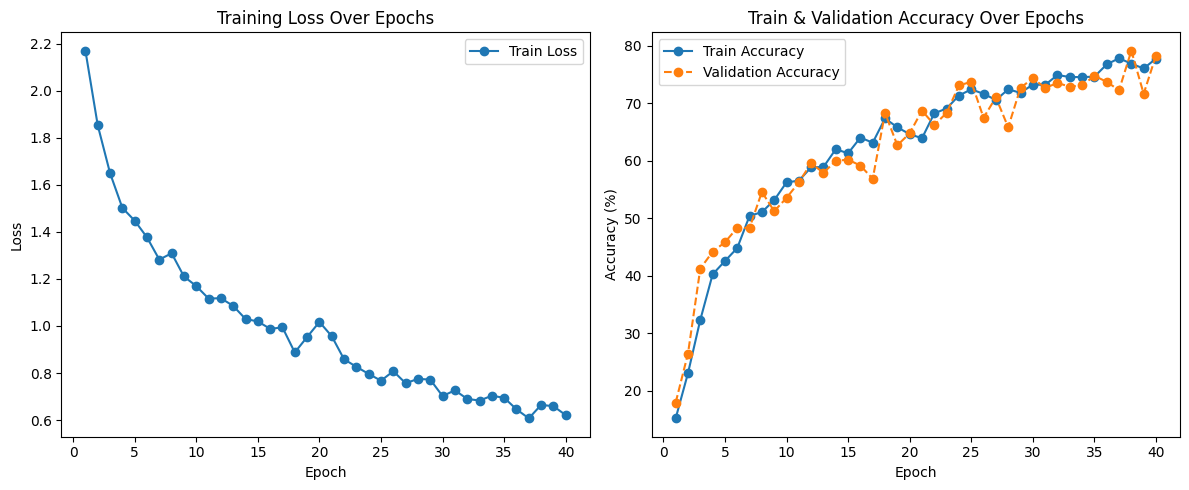

In [ ]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm

def save_results(filename, results):
    """Save results (accuracy, loss, etc.) to a CSV file."""
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")

def save_model(model, path):
    """Save trained model to a .pth file."""
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def plot_training_results(results):
    """Plots training loss, training accuracy, and validation accuracy over epochs."""
    epochs = results["epoch"]

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results["train_loss"], label="Train Loss", marker='o', linestyle='-')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [acc * 100 for acc in results["train_acc"]], label="Train Accuracy", marker='o', linestyle='-')
    plt.plot(epochs, [acc * 100 for acc in results["val_acc"]], label="Validation Accuracy", marker='o', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Train & Validation Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

def train_alexnet_with_logging_and_graph(dataset_path, batch_size=32, num_epochs=40, learning_rate=0.001, save_path="results"):
    """Train AlexNet, save results, and generate a training graph."""

    results_file = os.path.join(save_path, "training_results.csv")
    model_file = os.path.join(save_path, "alexnet_trained.pth")

    if os.path.exists(results_file) and os.path.exists(model_file):
        print("Training results already exist. Loading previous results.")
        return results_file, model_file

    os.makedirs(save_path, exist_ok=True)

    # Prepare dataset
    train_loader, val_loader, test_loader = create_dataloaders(dataset_path, batch_size)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load AlexNet without pre-trained weights
    model = models.alexnet(pretrained=False)
    num_classes = len(train_loader.dataset.dataset.classes)
    model.classifier[6] = torch.nn.Linear(4096, num_classes)
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    results = {"epoch": [], "train_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_acc = val_correct / val_total

        # Save epoch results
        results["epoch"].append(epoch + 1)
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")

    # Save results and model
    save_results(results_file, results)
    save_model(model, model_file)

    # Plot the training results
    plot_training_results(results)

    return results_file, model_file

# Run training with logging and graph
dataset_path = "/content/dataset/resampled_images"  # Usa il dataset ridotto
results_file, model_file = train_alexnet_with_logging_and_graph(dataset_path)


In [ ]:
import os

save_path = "results"
results_file = os.path.join(save_path, "training_results.csv")
model_file = os.path.join(save_path, "alexnet_trained.pth")

# Elimina i vecchi file di training
if os.path.exists(results_file):
    os.remove(results_file)
if os.path.exists(model_file):
    os.remove(model_file)

print("Old training results deleted. Starting new training session...")


Old training results deleted. Starting new training session...


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

def create_dataloaders(dataset_path, batch_size, train_perc=0.7, val_perc=0.2, seed=123):
    """
    Creates train, validation, and test DataLoaders from an ImageFolder dataset.
    Computes normalization stats automatically.
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
    ])

    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    dataset_size = len(dataset)
    train_size = int(train_perc * dataset_size)
    val_size = int(val_perc * dataset_size)
    test_size = dataset_size - train_size - val_size

    torch.manual_seed(seed)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


### Early Stopping and Learning Rate

To optimize the training process and ensure efficient use of computational resources, this training pipeline incorporates an **Early Stopping mechanism** and carefully chosen hyperparameters, including the **learning rate**. The goal is to enhance model performance while minimizing the risk of overfitting and unnecessary computation.



### Key Hyperparameters and Their Justification

1. **Early Stopping (Patience = 5):**  
   - The patience value is set to **5**, meaning the training will stop if there is **no improvement in validation loss for five consecutive epochs**.  
   - This value was chosen to strike a balance—allowing the model enough time to adjust and improve, while avoiding excessive training when no progress is being made.  
   - A patience of 5 is generally effective in reducing the risk of overfitting and saving time, especially when improvements in performance are marginal after several epochs.

2. **Learning Rate (0.001):**  
   - The learning rate determines how much the model's parameters are adjusted during each training step.  
   - A value of **0.001** is selected as it provides a **stable and gradual learning process**.  
   - This value ensures that the model can make consistent progress toward minimizing loss without making overly large updates that could destabilize learning.  
   - Choosing this rate helps in achieving an optimal balance between convergence speed and model stability.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/50: 100%|██████████| 53/53 [03:58<00:00,  4.50s/it]


Epoch 1/50 - Loss: 2.0094, Train Acc: 24.29%, Val Loss: 1.5468, Val Acc: 38.12%
Model saved to results/alexnet_trained.pth


Epoch 2/50: 100%|██████████| 53/53 [03:35<00:00,  4.06s/it]


Epoch 2/50 - Loss: 1.3307, Train Acc: 45.65%, Val Loss: 1.2149, Val Acc: 53.33%
Model saved to results/alexnet_trained.pth


Epoch 3/50: 100%|██████████| 53/53 [03:42<00:00,  4.20s/it]


Epoch 3/50 - Loss: 1.1466, Train Acc: 55.12%, Val Loss: 1.1489, Val Acc: 56.04%
Model saved to results/alexnet_trained.pth


Epoch 4/50: 100%|██████████| 53/53 [03:39<00:00,  4.15s/it]


Epoch 4/50 - Loss: 0.8893, Train Acc: 66.37%, Val Loss: 0.7904, Val Acc: 71.46%
Model saved to results/alexnet_trained.pth


Epoch 5/50: 100%|██████████| 53/53 [03:35<00:00,  4.07s/it]


Epoch 5/50 - Loss: 0.7008, Train Acc: 74.46%, Val Loss: 0.8263, Val Acc: 71.04%
Validation loss did not improve. Patience count: 1/5


Epoch 6/50: 100%|██████████| 53/53 [03:36<00:00,  4.08s/it]


Epoch 6/50 - Loss: 0.6397, Train Acc: 76.01%, Val Loss: 0.7352, Val Acc: 71.67%
Model saved to results/alexnet_trained.pth


Epoch 7/50: 100%|██████████| 53/53 [03:35<00:00,  4.06s/it]


Epoch 7/50 - Loss: 0.5823, Train Acc: 78.81%, Val Loss: 0.6589, Val Acc: 76.25%
Model saved to results/alexnet_trained.pth


Epoch 8/50: 100%|██████████| 53/53 [03:45<00:00,  4.25s/it]


Epoch 8/50 - Loss: 0.5906, Train Acc: 78.21%, Val Loss: 0.8670, Val Acc: 69.38%
Validation loss did not improve. Patience count: 1/5


Epoch 9/50: 100%|██████████| 53/53 [03:35<00:00,  4.07s/it]


Epoch 9/50 - Loss: 0.5552, Train Acc: 80.71%, Val Loss: 0.6263, Val Acc: 76.67%
Model saved to results/alexnet_trained.pth


Epoch 10/50: 100%|██████████| 53/53 [03:35<00:00,  4.07s/it]


Epoch 10/50 - Loss: 0.4850, Train Acc: 82.08%, Val Loss: 0.5101, Val Acc: 80.21%
Model saved to results/alexnet_trained.pth


Epoch 11/50: 100%|██████████| 53/53 [03:34<00:00,  4.04s/it]


Epoch 11/50 - Loss: 0.4260, Train Acc: 84.40%, Val Loss: 0.5314, Val Acc: 80.21%
Validation loss did not improve. Patience count: 1/5


Epoch 12/50: 100%|██████████| 53/53 [03:44<00:00,  4.23s/it]


Epoch 12/50 - Loss: 0.4973, Train Acc: 81.85%, Val Loss: 0.5339, Val Acc: 79.58%
Validation loss did not improve. Patience count: 2/5


Epoch 13/50: 100%|██████████| 53/53 [04:11<00:00,  4.74s/it]


Epoch 13/50 - Loss: 0.3375, Train Acc: 87.50%, Val Loss: 0.4454, Val Acc: 81.46%
Model saved to results/alexnet_trained.pth


Epoch 14/50: 100%|██████████| 53/53 [04:29<00:00,  5.09s/it]


Epoch 14/50 - Loss: 0.3584, Train Acc: 85.95%, Val Loss: 0.7351, Val Acc: 75.42%
Validation loss did not improve. Patience count: 1/5


Epoch 15/50: 100%|██████████| 53/53 [04:33<00:00,  5.17s/it]


Epoch 15/50 - Loss: 0.3217, Train Acc: 87.56%, Val Loss: 0.4063, Val Acc: 85.62%
Model saved to results/alexnet_trained.pth


Epoch 16/50: 100%|██████████| 53/53 [04:23<00:00,  4.98s/it]


Epoch 16/50 - Loss: 0.3408, Train Acc: 88.33%, Val Loss: 0.5888, Val Acc: 80.42%
Validation loss did not improve. Patience count: 1/5


Epoch 17/50: 100%|██████████| 53/53 [04:16<00:00,  4.85s/it]


Epoch 17/50 - Loss: 0.3500, Train Acc: 86.37%, Val Loss: 0.5308, Val Acc: 79.38%
Validation loss did not improve. Patience count: 2/5


Epoch 18/50: 100%|██████████| 53/53 [04:22<00:00,  4.96s/it]


Epoch 18/50 - Loss: 0.3198, Train Acc: 89.46%, Val Loss: 0.4861, Val Acc: 84.38%
Validation loss did not improve. Patience count: 3/5


Epoch 19/50: 100%|██████████| 53/53 [04:14<00:00,  4.80s/it]


Epoch 19/50 - Loss: 0.3239, Train Acc: 88.87%, Val Loss: 0.5575, Val Acc: 80.21%
Validation loss did not improve. Patience count: 4/5


Epoch 20/50: 100%|██████████| 53/53 [04:15<00:00,  4.82s/it]


Epoch 20/50 - Loss: 0.2588, Train Acc: 91.31%, Val Loss: 0.4271, Val Acc: 84.58%
Validation loss did not improve. Patience count: 5/5
Early stopping triggered. Stopping training.
Results saved to results/training_results.csv


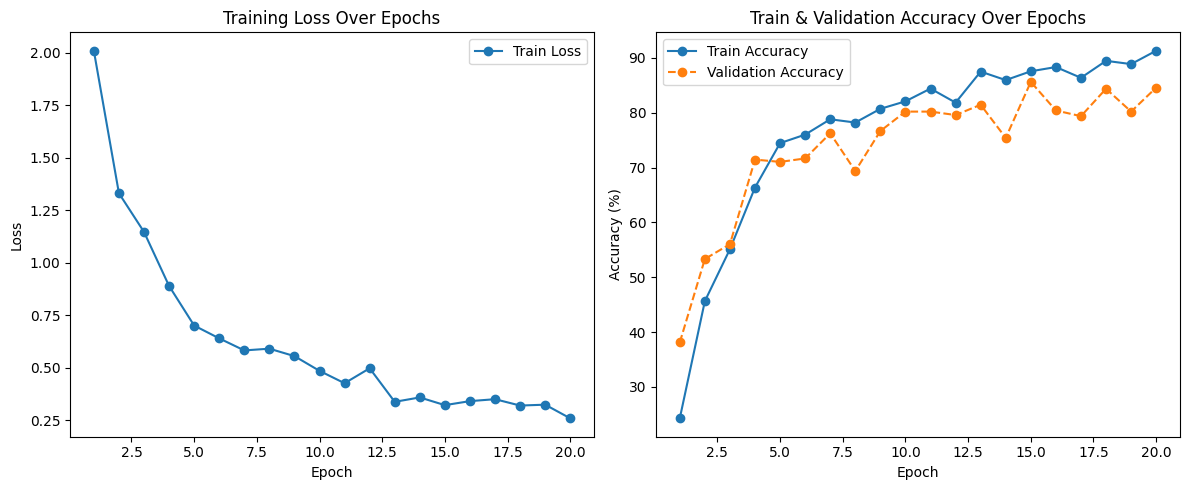

In [ ]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm

def save_results(filename, results):
    """Save results (accuracy, loss, etc.) to a CSV file."""
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")

def save_model(model, path):
    """Save trained model to a .pth file."""
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def plot_training_results(results):
    """Plots training loss, training accuracy, and validation accuracy over epochs."""
    epochs = results["epoch"]

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results["train_loss"], label="Train Loss", marker='o', linestyle='-')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [acc * 100 for acc in results["train_acc"]], label="Train Accuracy", marker='o', linestyle='-')
    plt.plot(epochs, [acc * 100 for acc in results["val_acc"]], label="Validation Accuracy", marker='o', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Train & Validation Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

def train_alexnet_with_early_stopping(dataset_path, batch_size=32, num_epochs=50, learning_rate=0.001, patience=5, save_path="results"):
    """Train AlexNet, save results, and generate a training graph with Early Stopping."""

    results_file = os.path.join(save_path, "training_results.csv")
    model_file = os.path.join(save_path, "alexnet_trained.pth")

    os.makedirs(save_path, exist_ok=True)

    # Prepare dataset
    train_loader, val_loader, test_loader = create_dataloaders(dataset_path, batch_size)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load AlexNet without pre-trained weights
    model = models.alexnet(pretrained=False)
    num_classes = len(train_loader.dataset.dataset.classes)
    model.classifier[6] = torch.nn.Linear(4096, num_classes)
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    results = {"epoch": [], "train_loss": [], "train_acc": [], "val_acc": []}

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # Save epoch results
        results["epoch"].append(epoch + 1)
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

        # Check Early Stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            save_model(model, model_file)  # Save the best model
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience count: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

    # Save results and model
    save_results(results_file, results)

    # Plot the training results
    plot_training_results(results)

    return results_file, model_file

# Run training with Early Stopping

results_file, model_file = train_alexnet_with_early_stopping(dataset_path, num_epochs=50, patience=5)


### Analysis of Training Results

The provided graphs illustrate the **training loss** and the **train-validation accuracy** trends over 20 epochs.


### 1. Training Loss Over Epochs (Left Graph)

- The training loss shows a **consistent and steady decrease** across epochs, starting from around **2.0** and dropping to approximately **0.25** by the 20th epoch.  
- The sharp decline in the initial epochs indicates that the model quickly learned the basic patterns in the data.  
- The gradual stabilization of the loss in later epochs suggests that the model has reached a point of **convergence**, where further training yields smaller improvements.  
- Minor fluctuations in the later stages are expected but remain within a stable range, indicating good training behavior.


### 2. Training and Validation Accuracy Over Epochs (Right Graph)

- Both training and validation accuracy show a **significant improvement** during the early epochs, demonstrating that the model effectively learned from the data.  
- Training accuracy continues to improve steadily, eventually exceeding **90%**, while validation accuracy stabilizes around **80-85%**.  
- The gap between training and validation accuracy suggests a **slight overfitting**, as the model performs better on the training data compared to the validation set. However, the gap is not excessive, indicating that the model still generalizes reasonably well.  
- The fluctuations in validation accuracy are normal and could be influenced by variations in the validation data or the complexity of the task.


Overall, these results demonstrate that the training process was effective, with the model showing good learning capability and reasonable generalization to unseen data.
